In [1]:
# import the necessary packages
import matplotlib.pyplot as plt
from sklearn.datasets.samples_generator import make_blobs
import numpy as np
import pandas as pd
import FixedPoint
from math import exp

# Parameters

In [2]:
epochs = 100
alpha = 0.01
s_batch = 32

In [3]:
n_features = 50

In [4]:
input_prec = (10,10)
inter_prec = (10,10)
output_prec = (10,10)

# utility functions

In [5]:
def sigmoid_activation(x):
	# compute and return the sigmoid activation value for a
	# given input value
    family = x.get_value(0,0).family
    if type(x) == type(pd.DataFrame([0])):
        return x.applymap(
            lambda v: 
            FixedPoint.FXnum(
                1/(1+exp(-float(v))),
                family
            ) 
        )
    elif type(x) == type(pd.Series([0])):
        return x.map(
            lambda v: 
            FixedPoint.FXnum(
                1/(1+exp(-float(v))),
                family
            ) 
        )

In [6]:
def next_batch(X, y, batchSize):
	# loop over our dataset `X` in mini-batches of size `batchSize`
	for i in np.arange(0, X.shape[0], batchSize):
		# yield a tuple of the current batched data and labels
		yield (X[i:i + batchSize], y[i:i + batchSize])

# The function

# Gradient Function

In [7]:
def calc_gradint(X,y,W):
    # take the dot product between our features `X` and the
    # weight matrix `W`, then pass this value through the
    # sigmoid activation function, thereby giving us our
    # predictions on the dataset
    preds = sigmoid_activation(X.dot(W))
    
    # now that we have our predictions, we need to determine
    # our `error`, which is the difference between our predictions
    # and the true values
    error = preds - y
 
    # given our `error`, we can compute the total loss value as
    # the sum of squared loss -- ideally, our loss should
    # decrease as we continue training
    loss = (error ** 2).sum()
    return (X.T.dot(error) / X.shape[0],loss)

# Generate the dataset

In [8]:
# generate a 2-class classification problem with 250 data points,
# where each data point is a 2D feature vector
(X, y) = make_blobs(n_samples=250, n_features=n_features, centers=2,
	cluster_std=10.0, random_state=95)

# conver to pandas dataframe
y = pd.DataFrame(y)

# insert a column of 1's as the first entry in the feature
# vector -- this args["epochs"]is a little trick that allows us to treat
# the bias as a trainable parameter *within* the weight matrix
# rather than an entirely separate variable
X = pd.DataFrame(np.c_[np.ones((X.shape[0])), X])
 
# initialize our weight matrix such it has the same number of
# columns as our input features
W = pd.DataFrame(np.random.uniform(size=(X.shape[1],)))
 
# initialize a list to store the loss value for each epoch
lossHistory = []

In [9]:
# floating point data
f_X = X.applymap(
    lambda v: FixedPoint.FXnum(
            v,FixedPoint.FXfamily(n_bits=input_prec[0], n_intbits=input_prec[1])
    )
)
f_W = W.applymap(
    lambda v: FixedPoint.FXnum(
            v,FixedPoint.FXfamily(n_bits=inter_prec[0], n_intbits=inter_prec[1])
    )
)
f_y = y.applymap(
    lambda v: FixedPoint.FXnum(
            v,FixedPoint.FXfamily(n_bits=output_prec[0], n_intbits=output_prec[1])
    )
)

# Run the SGD

In [10]:
gradient,loss = calc_gradint(f_X,f_y,f_W)
preds = sigmoid_activation(f_X.dot(f_W))
error = preds - f_y

In [12]:
f_X.T.dot(error)

,0
0,8.693
1,-366.414
2,177.745
3,70.413
4,-17.322
5,-382.629
6,None
7,279.744
8,None
9,-184.321


In [12]:
error.shape

(250, 1)

In [10]:
# loop over the desired number of epochs
for epoch in np.arange(0, epochs):
	# the gradient update is therefore the dot product between
	# the transpose of `X` and our error, scaled by the total
	# number of data points in `X`
	gradient,loss = calc_gradint(f_X,f_y,f_W)
    
    # keep track of the losses in each epoch
	lossHistory.append(loss)

	# in the update stage, all we need to do is nudge our weight
	# matrix in the negative direction of the gradient (hence the
	# term "gradient descent" by taking a small step towards a
	# set of "more optimal" parameters
	f_W += -alpha * gradient


ValueError: cannot convert float NaN to integer

# Sample Predictions

In [193]:
# to demonstrate how to use our weight matrix as a classifier,
# let's look over our a sample of training examples
for i in np.random.choice(250, 10):
	# compute the prediction by taking the dot product of the
	# current feature vector with the weight matrix W, then
	# passing it through the sigmoid activation function
	activation = sigmoid_activation(f_X.iloc[i].dot(f_W))
 
	# the sigmoid function is defined over the range y=[0, 1],
	# so we can use 0.5 as our threshold -- if `activation` is
	# below 0.5, it's class `0`; otherwise it's class `1`
	label = 0 if activation[0] < 0.5 else 1
 
	# show our output classification
	print("activation={:.4f}; predicted_label={}, true_label={}"
          .format(float(activation[0]), label, float(f_y.iloc[i]) ))

activation=1.0000; predicted_label=1, true_label=1.0
activation=1.0000; predicted_label=1, true_label=1.0
activation=1.0000; predicted_label=1, true_label=1.0
activation=1.0000; predicted_label=1, true_label=1.0
activation=0.0000; predicted_label=0, true_label=0.0
activation=1.0000; predicted_label=1, true_label=1.0
activation=1.0000; predicted_label=1, true_label=1.0
activation=0.0000; predicted_label=0, true_label=0.0
activation=0.0000; predicted_label=0, true_label=0.0
activation=0.0000; predicted_label=0, true_label=0.0


# Calculating accuracy

In [194]:
def get_precision(X,W,y):
    prediction = sigmoid_activation(X.dot(W));
    error = (np.sign( np.multiply(prediction-0.5,y-0.5) )+1)/2;
#     return np.mean(error);
    return np.mean(error);
#     return error

In [195]:
get_precision(f_X,f_W,f_y)

0    0.992
dtype: float64

# plot Training Loss

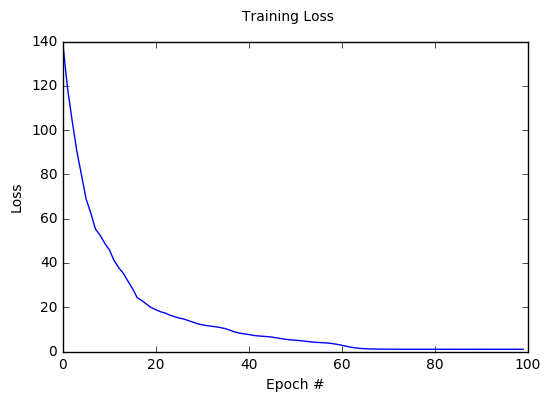

In [185]:
# construct a figure that plots the loss over time
fig = plt.figure()
plt.plot(np.arange(0, epochs), lossHistory)
fig.suptitle("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.show()